In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm
import pickle

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id_idx = 1
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
experiment_id = experiment_ids[experiment_id_idx]
round_ids = ["ARN", "R01", "R02N"]

In [3]:
dtype = torch.float32
device = utils.best_device()

Selected device: cuda


In [4]:
(sequences, sequences_unique, counts, log_multinomial_factors, 
 sequences_unique_all, counts_unique) = \
    utils.sequences_from_files_detailed(experiment_id, round_ids)

Extracting sequences from 3 files...
Finished round ARN
Finished round R01
Finished round R02N
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round ARN...
Finished


In [5]:
train_valid_idx = torch.load(f'saved/train_test_split/{experiment_id}.pt')
idx_train = train_valid_idx['idx_train']
idx_valid = train_valid_idx['idx_valid']

In [6]:
((sequences_oh, total_reads, log_multinomial_factors), 
 (sequences_valid_oh, total_reads_valid, log_multinomial_factors_valid)) = \
    data_loading.split_train_test(sequences_unique_all, counts_unique, idx_train, idx_valid)

In [7]:
total_reads = total_reads.to(device)
log_multinomial_factors = log_multinomial_factors.to(device)
total_reads_valid = total_reads_valid.to(device)
log_multinomial_factors_valid = log_multinomial_factors_valid.to(device)

In [8]:
fi_tuple, fij_tuple, _ = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)
fij = torch.stack(fij_tuple)
_, L, q = fi.size()

In [9]:
torch.save((fi.clone().cpu(), total_reads.clone().cpu()), f'saved/fi_{experiment_id}.pt')

In [10]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')
k_indep = model_indep.round_zero.set_zerosum_gauge().h.detach().clone()
h_indep = model_indep.selection.modes[0].set_zerosum_gauge().h.detach().clone()

In [43]:
from importlib import reload
reload(energy_models)
reload(utils)
reload(training)
reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/experiments/../callback.py'>

In [47]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

# k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
k = k_indep.clone()
# h = torch.zeros(L, q, dtype=dtype)
h = h_indep.clone()
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [48]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]
n_rounds = len(data_loaders) 

In [49]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [50]:
weight_decay = 0.0
lr = 0.0001

optimizer = torch.optim.AdamW([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [51]:
# from importlib import reload
# reload(utils)
# reload(callback)
# reload(training)
# reload(sampling)
# reload(selex_distribution)
# reload(energy_models)
# reload(data_loading)

In [52]:
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_init'
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             # callback.CheckpointCallback(save_every=checkpoint_every, checkpoint_filename=checkpoint_filename, delete_old_checkpoints=True),
             callback.ParamsCallback(save_every=100)]

In [ ]:
n_sweeps = 10
max_epochs = 10000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors, log_multinomial_factors_valid=log_multinomial_factors_valid,
               data_loaders_valid=data_loaders_valid, total_reads_valid=total_reads_valid)

 0.00%[                                                                                                       …

In [ ]:
callbacks[0].plot();

In [ ]:
callbacks[0].plot_pearson_detail();

In [ ]:
callbacks[1].plot();

In [ ]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

In [ ]:
fig, axes = callbacks[-1].plot(plot_every=1)
for ax in axes:
    ax.legend().remove()

In [ ]:
Js = list(zip(*callbacks[-1].params))[1]
norms = [torch.linalg.norm(J) for J in Js]
plt.plot(norms)

In [ ]:
Fs = [selex_dca.get_contact_map(utils.zerosum_gauge_couplings(J)) for J in Js]
for n in range(0, len(Fs), 10):
    pl, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(Fs[n])
    ax.set_xlabel("i"); ax.set_ylabel("i")
    plt.colorbar(im)
    plt.tight_layout()
    ax.set_title(f'After {n} iterations')

In [ ]:
potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [ ]:
# torch.save(model, f'saved/{checkpoint_filename}.pt')

## Check equilibration

In [ ]:
n_chains_equil = 10**3
chains_fi = training.init_chains(n_rounds, n_chains_equil, L, q, dtype=dtype, device=device, fi=fi)
chains_indep = training.init_chains(n_rounds, n_chains_equil, L, q, dtype=dtype, device=device)

model.sample(chains_fi, n_sweeps=100)
model.sample(chains_indep, n_sweeps=100);

In [ ]:
n_max_sweeps = 10**3

mixing_times_fi, fig_fi = sampling.compute_and_plot_mixing_time(model, chains_fi, n_max_sweeps)

In [ ]:
n_max_sweeps = 10**3

mixing_times_indep, fig_indep = sampling.compute_and_plot_mixing_time(model, chains_indep, n_max_sweeps)

In [466]:
L_data = 0
model.zero_grad()
for t in range(n_rounds):
    L_d = - model.compute_energy_up_to_round(batches[t].clone(), t).mean()
    L_data += total_reads[t] * L_d / log_likelihood_normaliz
grad_data = training.compute_grad_data(model, L_data, retain_graph=False)
# grad_data = torch.nn.utils.parameters_to_vector(grad_data)

L_model_fi = 0
model.zero_grad()
for t in range(n_rounds):
    L_m = - model.compute_energy_up_to_round(chains_fi[t].clone(), t).mean()
    L_model_fi += total_reads[t] * L_m / log_likelihood_normaliz
grad_model_fi = training.compute_grad_data(model, L_model_fi, retain_graph=False)
# grad_model_fi = torch.nn.utils.parameters_to_vector(grad_model_fi)

L_model_indep = 0
model.zero_grad()
for t in range(n_rounds):
    L_m = - model.compute_energy_up_to_round(chains_indep[t].clone(), t).mean()
    L_model_indep += total_reads[t] * L_m / log_likelihood_normaliz
grad_model_indep = training.compute_grad_data(model, L_model_indep, retain_graph=False)
# grad_model_indep = torch.nn.utils.parameters_to_vector(grad_model_indep)

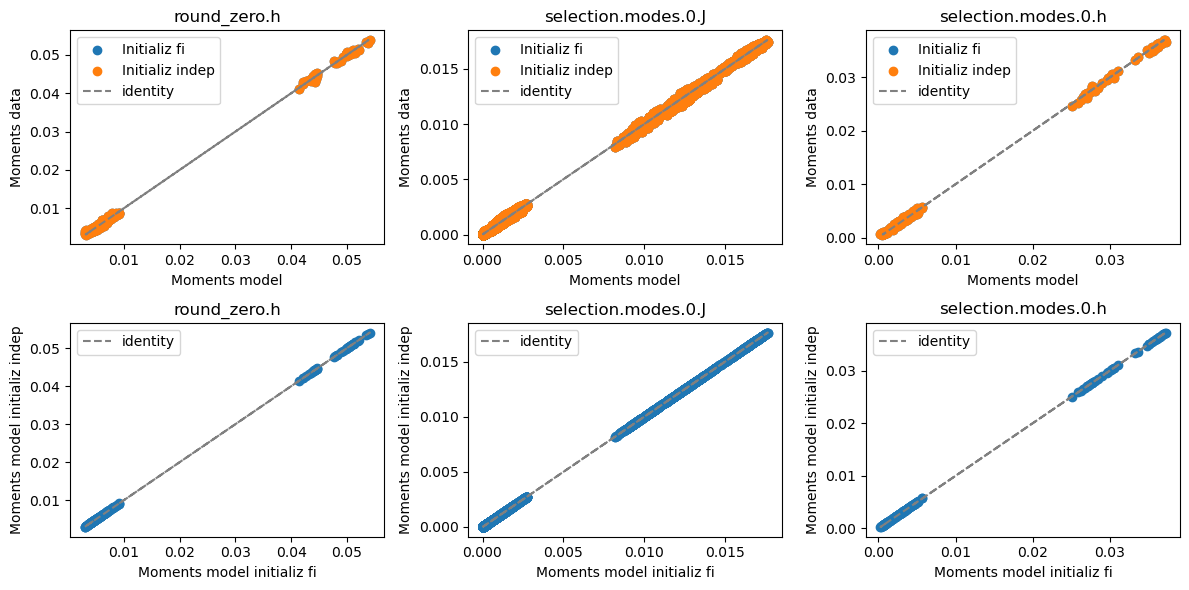

In [467]:
n_param = len(list(model.named_parameters()))

fig, axes = plt.subplots(2, n_param, figsize=(12,6))
for (i, (param_name, _)) in enumerate(model.named_parameters()):
    ax = axes[0, i]
    ax.scatter(grad_model_fi[i].cpu(), grad_data[i].cpu(), label='Initializ fi')
    ax.scatter(grad_model_indep[i].cpu(), grad_data[i].cpu(), label='Initializ indep')
    ax.plot(grad_data[i].cpu().reshape(-1), grad_data[i].cpu().reshape(-1), label='identity', color='gray', ls='--')
    ax.legend()
    ax.set_xlabel('Moments model')
    ax.set_ylabel('Moments data')
    ax.set_title(param_name)

    ax = axes[1, i]
    ax.scatter(grad_model_fi[i].cpu(), grad_model_indep[i].cpu())
    ax.plot(grad_model_fi[i].cpu().reshape(-1), grad_model_fi[i].cpu().reshape(-1), label='identity', color='gray', ls='--')
    ax.legend()
    ax.set_xlabel('Moments model initializ fi')
    ax.set_ylabel('Moments model initializ indep')
    ax.set_title(param_name)
fig.tight_layout()

In [ ]:
n_chains = 10**4
n_sweeps = 1
step = 0.0001

In [ ]:
batches = [next(iter(dl)) for dl in data_loaders]

nll_train = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
nll_train

In [ ]:
batches = [next(iter(dl)) for dl in data_loaders_valid]
nll_valid = - training.estimate_log_likelihood_AIS(model, batches, total_reads_valid, log_multinomial_factors_valid, n_chains, n_sweeps, step)
nll_valid

## Logo for fields

In [468]:
import logomaker
import pandas as pd

In [469]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

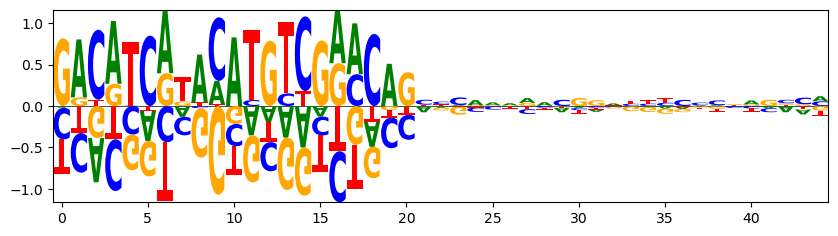

In [470]:
logomaker.Logo(pd.DataFrame(h, columns=list(utils.TOKENS_DNA)));

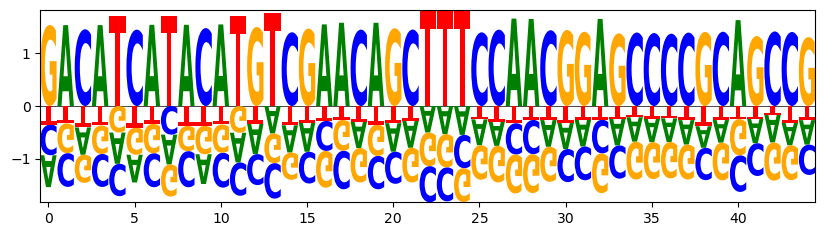

In [471]:
k = model.round_zero.set_zerosum_gauge().h.detach().cpu()
logomaker.Logo(pd.DataFrame(k, columns=list(utils.TOKENS_DNA)));

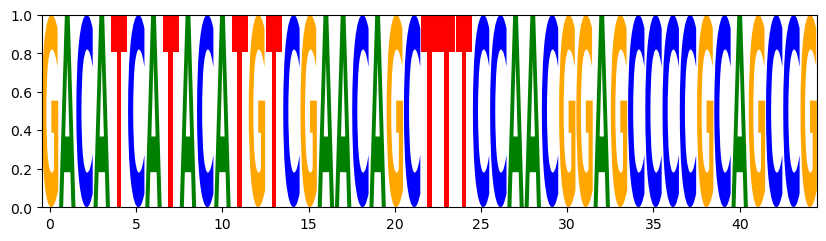

In [472]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

wt_oh = utils.one_hot(wts[experiment_id_idx])
logomaker.Logo(pd.DataFrame(wt_oh, columns=list(utils.TOKENS_DNA)));

## Change weight decay

In [473]:
import copy
model_cp = copy.deepcopy(model)

In [480]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

# k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
k = k_indep.clone()
# h = torch.zeros(L, q, dtype=dtype)
h = h_indep.clone()
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [481]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]
n_rounds = len(data_loaders) 

In [482]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [483]:
weight_decay = 1e-2
lr = 0.01

optimizer = torch.optim.SGD([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [484]:
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_init'
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, checkpoint_filename=checkpoint_filename, delete_old_checkpoints=True),
             callback.ParamsCallback(save_every=100)]

In [485]:
n_sweeps = 10
max_epochs = 10**3

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors, log_multinomial_factors_valid=log_multinomial_factors_valid,
               data_loaders_valid=data_loaders_valid, total_reads_valid=total_reads_valid)

 0.00%[                                                                                                       …

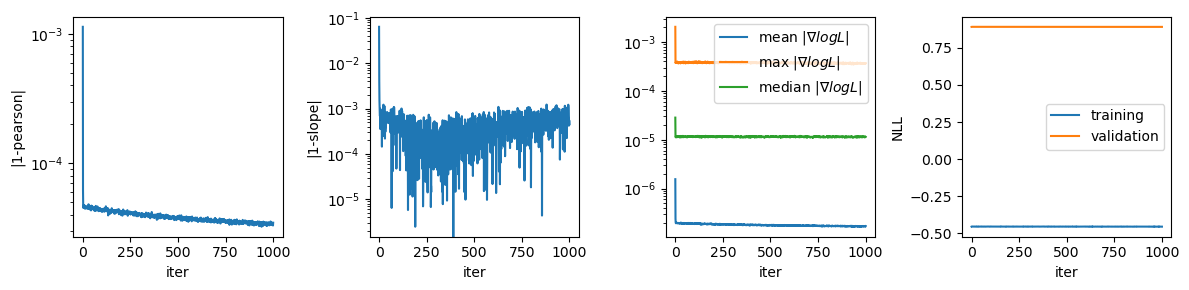

In [486]:
callbacks[0].plot();

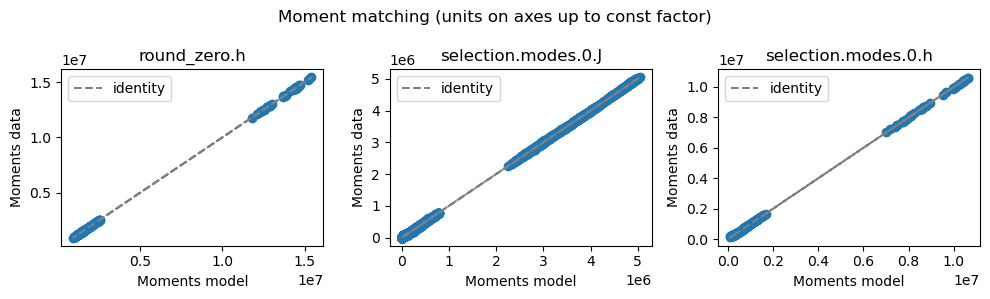

In [487]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

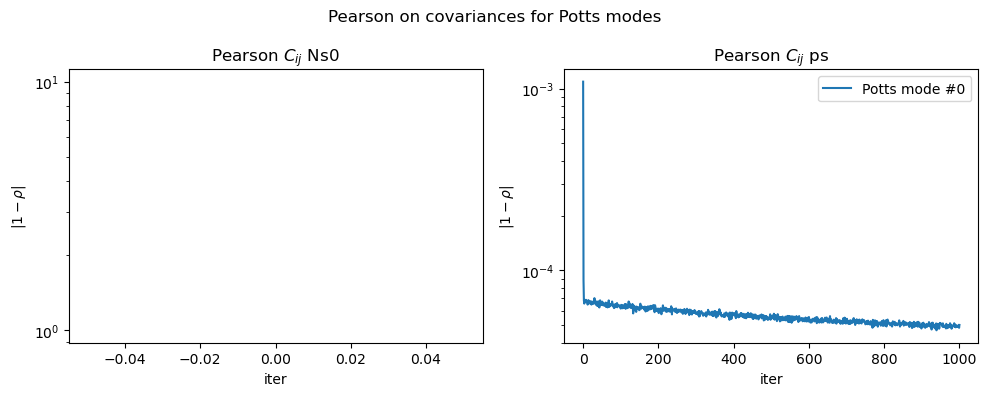

In [488]:
callbacks[1].plot();

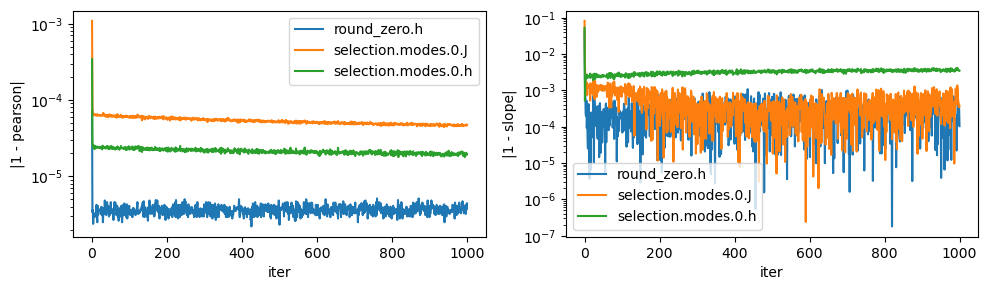

In [489]:
callbacks[0].plot_pearson_detail();

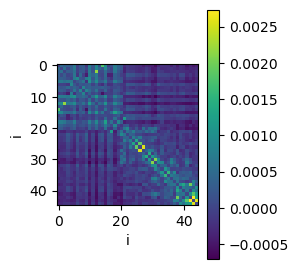

In [490]:
potts_zerosum = potts.set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [491]:
torch.save(model, f'saved/{checkpoint_filename}.pt')

## Change weight decay again

In [492]:
import copy
model_cp2 = copy.deepcopy(model)

In [493]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

# k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
k = k_indep.clone()
# h = torch.zeros(L, q, dtype=dtype)
h = h_indep.clone()
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [494]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]
n_rounds = len(data_loaders) 

In [495]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [496]:
weight_decay = 1e-1
lr = 0.01

optimizer = torch.optim.SGD([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [497]:
# from importlib import reload
# reload(utils)
# reload(callback)
# reload(training)
# reload(sampling)
# reload(selex_distribution)
# reload(energy_models)
# reload(data_loading)

In [498]:
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_init'
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, checkpoint_filename=checkpoint_filename, delete_old_checkpoints=True),
             callback.ParamsCallback(save_every=100)]

In [499]:
n_sweeps = 10
max_epochs = 10**3

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors, log_multinomial_factors_valid=log_multinomial_factors_valid,
               data_loaders_valid=data_loaders_valid, total_reads_valid=total_reads_valid)

 0.00%[                                                                                                       …

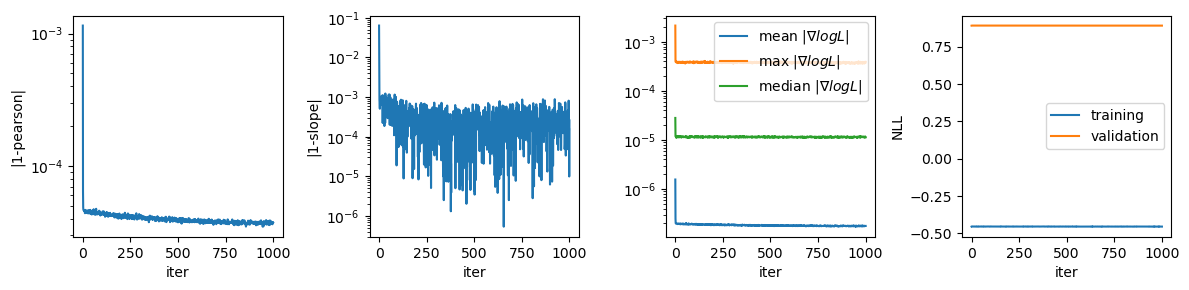

In [500]:
callbacks[0].plot();

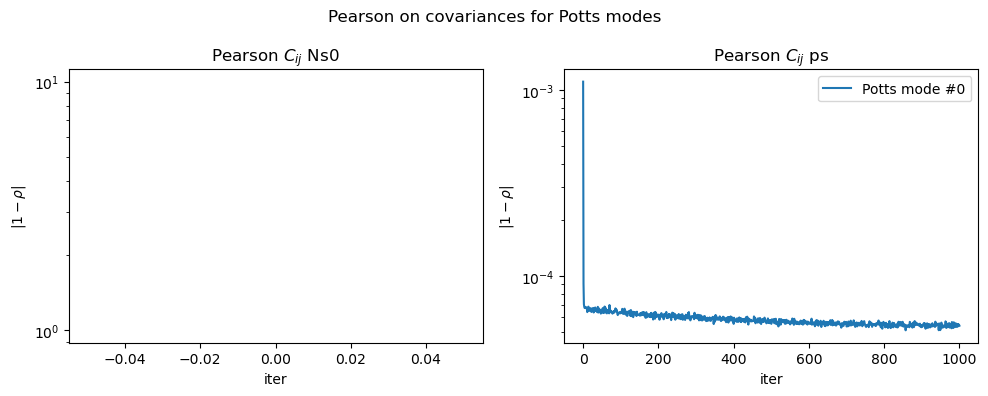

In [501]:
callbacks[1].plot();

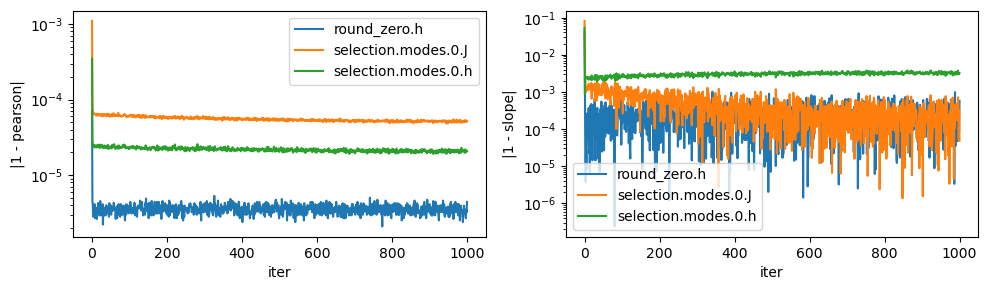

In [502]:
callbacks[0].plot_pearson_detail();

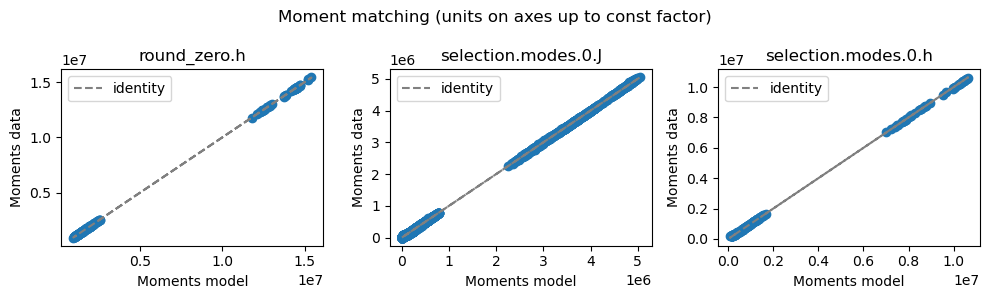

In [503]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

<IPython.core.display.Latex object>

Multi-round


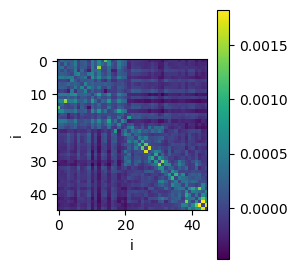

In [504]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

In [505]:
torch.save(model, f'saved/{checkpoint_filename}.pt')

## Change weight decay again again

In [506]:
import copy
model_cp3 = copy.deepcopy(model)

In [507]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

# k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
k = k_indep.clone()
# h = torch.zeros(L, q, dtype=dtype)
h = h_indep.clone()
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [508]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
data_loaders_valid = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_valid_oh]
n_rounds = len(data_loaders) 

In [509]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [510]:
weight_decay = 1e0
lr = 0.01

optimizer = torch.optim.SGD([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [511]:
# from importlib import reload
# reload(utils)
# reload(callback)
# reload(training)
# reload(sampling)
# reload(selex_distribution)
# reload(energy_models)
# reload(data_loading)

In [512]:
checkpoint_filename = experiment_id + f'_wd_{weight_decay}_init'
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, checkpoint_filename=checkpoint_filename, delete_old_checkpoints=True),
             callback.ParamsCallback(save_every=100)]

In [513]:
n_sweeps = 10
max_epochs = 10**3

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors, log_multinomial_factors_valid=log_multinomial_factors_valid,
               data_loaders_valid=data_loaders_valid, total_reads_valid=total_reads_valid)

 0.00%[                                                                                                       …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



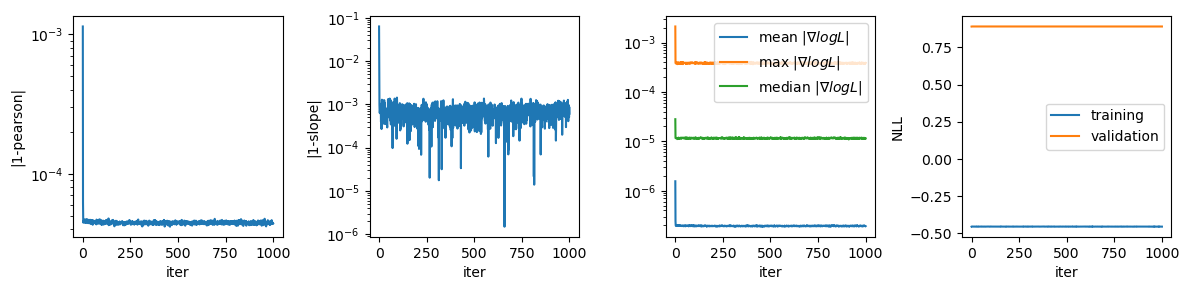

In [514]:
callbacks[0].plot();

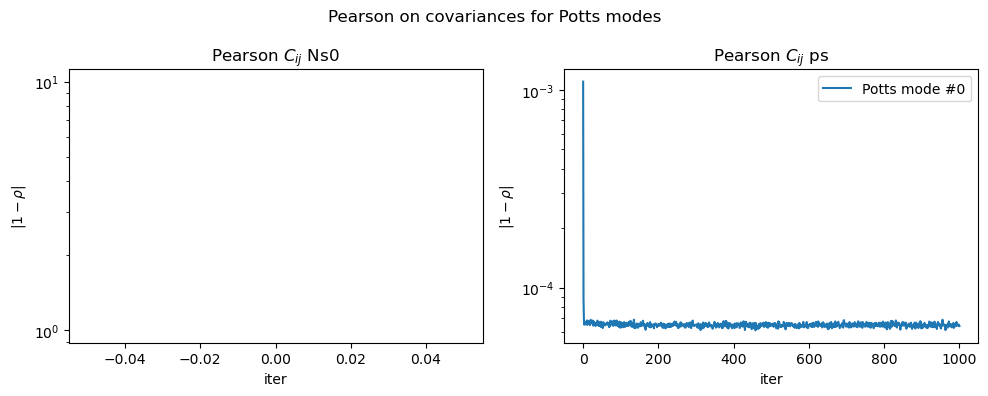

In [515]:
callbacks[1].plot();

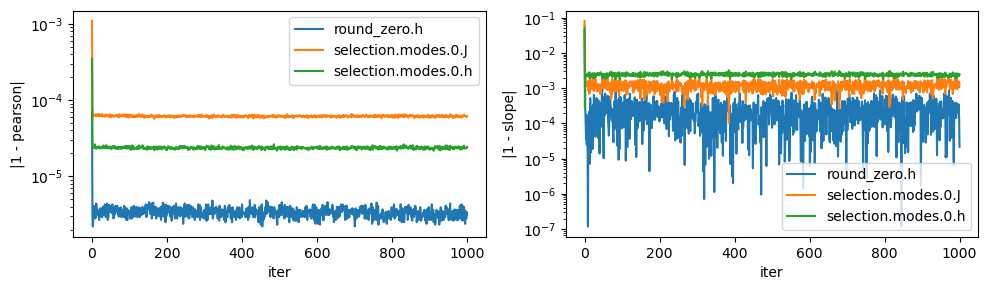

In [516]:
callbacks[0].plot_pearson_detail();

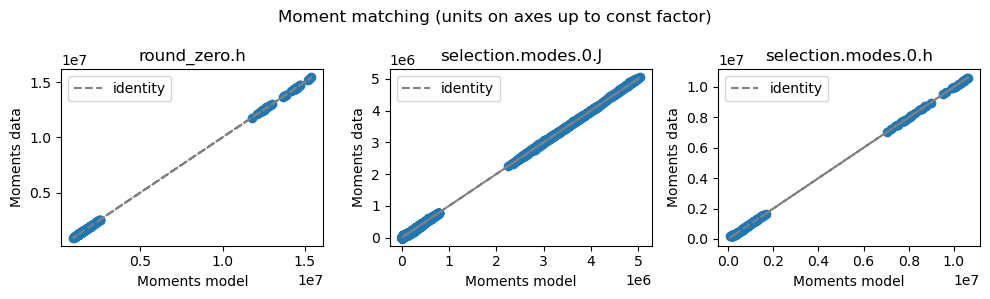

In [517]:
training.scatter_moments(model, data_loaders, chains, total_reads, figsize=(10,3));

<IPython.core.display.Latex object>

Multi-round


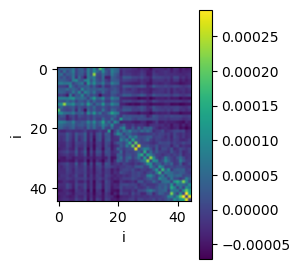

In [518]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge().cpu()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

In [519]:
torch.save(model, f'saved/{checkpoint_filename}.pt')